In [2]:
import tensorflow as tf
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import pickle
from collections import Counter
import json
import subprocess
import keras_hub

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2025-10-13 22:16:42.034770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/archfishgame/deep/deep-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.16.2
1 Physical GPUs, 1 Logical GPUs


2025-10-13 22:16:45.250163: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-13 22:16:49.287271: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-13 22:16:49.287318: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-13 22:16:49.288113: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-13 22:16:49.288173: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

## Approach  

Since the data we have is from the paper "Xie, N., Lai, F., Doran, D., & Kadav, A. (2019). Visual Entailment: A Novel Task for Fine-Grained Image Understanding. ArXiv, abs/1901.06706." I began by looking at their approach. As ilistraited below this modal first extracts feature data from the text and images using a combination of token embedding, RCNN and self attention, then attention is computed between the 2 encoded features that is fed through a MLP to generate the final output. This paper doesn't use transformers and was written before they became dominant in the text and image processing space so I decided I wanted to investigate trying to use transformers to encode the image and text features.       

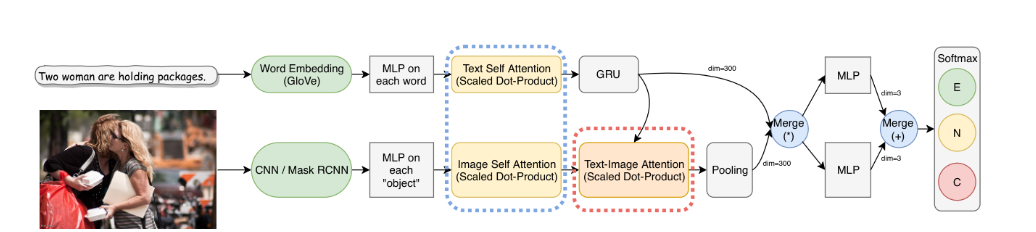

I found a paper "Hu, R., & Singh, A. (2021). UniT: Multimodal Multitask Learning with a Unified Transformer. 2021 IEEE/CVF International Conference on Computer Vision (ICCV), 1419-1429." that applied transformers to this task and leveraging transfer learning to better extract generalized features from image and text inputs. 

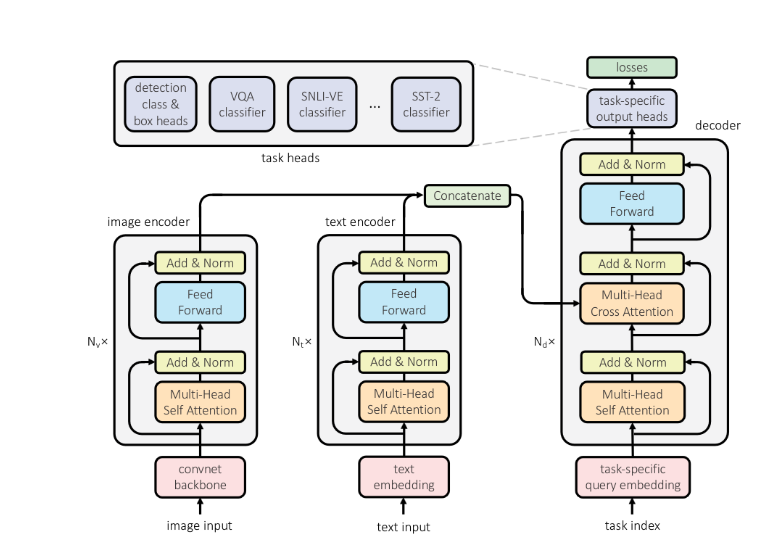

I decided that I would use transformers for feature extraction like the UniT paper but because I was only training the model for the one task I opted to use an MLP and attention combination similar to the Visual Entailment paper.    

## Exploring the data

I loaded all the training image names and their attached tokenized hypothesis and labels.

I printed out the size of the dataset and the ratio of entangled to contradictory images in the dataset as well as a random sample of images to get an idea of how the dataset looks. 

The ratio of entailment to contradiction appears to be close to 1 to 1 with on average one of each for every image this means that the dataset should be fairly balanced and I shouldn't need to augment the data to account for imbalance in training. 
On the other hand the images have differing resolutions that will require scaling to a common resolution for the model to be able to process correctly. 
Looking at the images there is a wide variety of lighting conditions, backgrounds, and resolutions this information will be useful for implementing data augmentation.   

Number of images 19573
Vocab length 9274
hypothesis count 39129
Dataset balance Counter({'entailment': 19619, 'contradiction': 19510})


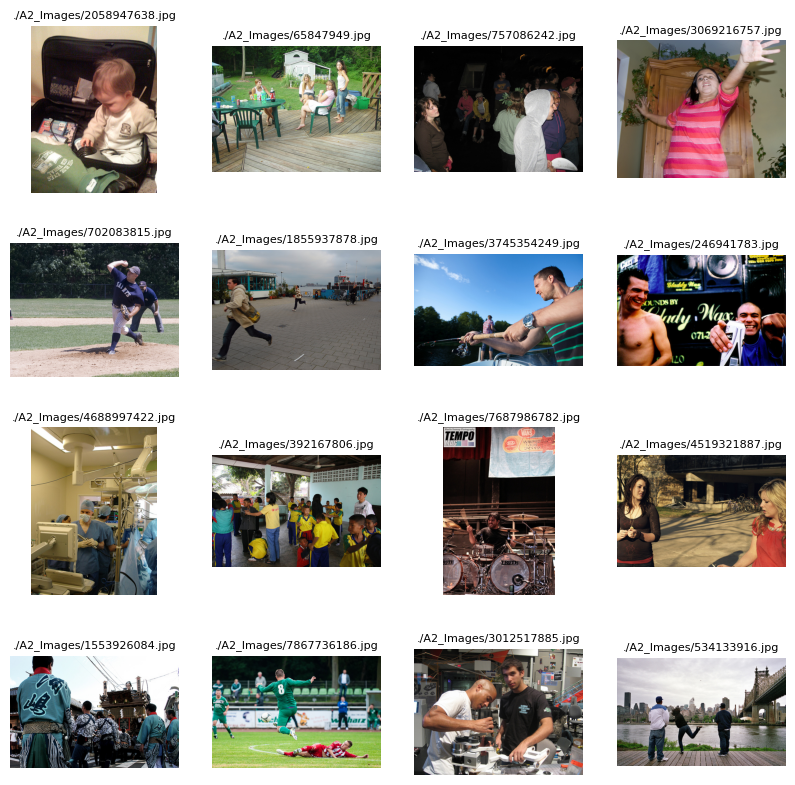

In [3]:
# load images and labels 

labelSet = Counter()
dataDict = {}
vocab = set()

datasetLen = 0
with open("./A2_train_v3.jsonl", "r") as jsonFile:
	for line in jsonFile:
		datasetLen += 1
		loadedLine = json.loads(line)
		if loadedLine["Image_ID"] not in dataDict:
			dataDict[loadedLine["Image_ID"]] = []

		labelSet[loadedLine["Label"]] += 1

		hypo = [''.join(char for char in word if char.isalnum()) for word in loadedLine["Hypothesis"].lower().split()]
		vocab.update(hypo)

		dataDict[loadedLine["Image_ID"]].append((hypo, loadedLine["Label"]))

labelTuple = tuple(labelSet.keys())
vocab = list(vocab)

vocabIndex = {vocab[i]: i for i in range(len(vocab))}

print(f'Number of images {len(dataDict.keys())}')
print(f'Vocab length {len(vocabIndex)}')
print(f'hypothesis count {datasetLen}')
print(f'Dataset balance {labelSet}')

gridSize = 4
plt.figure(figsize=(10, 10)) 

for i in range(gridSize ** 2):
	image_file = './A2_Images/' + random.choice(list(dataDict.keys())) + '.jpg'
	img = mpimg.imread(image_file)

	plt.subplot(gridSize, gridSize, i + 1)
	plt.imshow(img)
	plt.title(image_file, fontsize=8)
	plt.axis('off') # Hide axes for cleaner image display

plt.show()

## Word embeddings 

I used the glove pretrained embeddings for the text input because they have proved useful in capturing meaning of text in many other papers and they were trained on a far larger dataset of text than the one I have and therefor the embedings are morelikely to capture the true meaning of text tokens then any embeddings I can create.   


In [4]:
# load the glove embeddings 

def getGlove():
  print('Downloading glove')
  subprocess.run(['wget', 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'])
  subprocess.run(['unzip', '-q glove.6B.zip'])

def generateMatrix(dim):
    print('parsing glove data')
    embeddingMatrix = np.zeros((len(vocab), dim))
    embeddedVocab = []
    
    with open(f'glove.6B.{dim}d.txt', encoding="utf-8") as gloveFile:
      for line in gloveFile:
        values = line.split()
        word = values[0]
    
        if word in vocab:
          embeddingMatrix[vocabIndex[word]] = np.asarray(values[1:], dtype='float32')
          embeddedVocab.append(word)

    print(f'embedded {len(embeddedVocab)} out of {len(vocab)}')
    return embeddingMatrix, [i for i in vocab if i not in embeddedVocab]


embeddingDim = 200
embeddingMatrix = None
notEmbeddedVocab = None

if not os.path.isfile(f'glove.6B.{embeddingDim}d.txt'):
  getGlove()

if os.path.isfile(f'embeddingMatrix.{embeddingDim}d.pkl'):
  with open(f'embeddingMatrix.{embeddingDim}d.pkl', 'rb') as f:
    embeddingMatrix = pickle.load(f)

  print('loaded matrix')
else:
  embeddingMatrix, notEmbeddedVocab = generateMatrix(embeddingDim)

  with open(f'embeddingMatrix.{embeddingDim}d.pkl', 'ab') as f:
    pickle.dump(embeddingMatrix, f)

  print('saved matrix')

  print(len(notEmbeddedVocab))

loaded matrix


## Creating the dataset 

I chose to scale all the images down to a resolution of 224 by 224 because this is a resolution commonly used by imagenet (this fact will be important when I get the the model structure) it also makes the dataset smaller and easy to work with while not loosing too much information in the process.  

In [5]:
maxLen = 128
imageChannels = 3
imageRes = 224
patchesPerImage = 8

X1array = []
X2array = []
YArray = []

for key, hypoAndLabels in dataDict.items():
	img = f'./A2_Images/{key}.jpg'

	for hypo, label in hypoAndLabels:
		label = tf.convert_to_tensor([labelTuple.index(label)])
		label.set_shape([1])

		hypo = [vocabIndex[word] for word in hypo]
		hypo = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([hypo], maxlen=maxLen)[0])
		hypo.set_shape([maxLen])

		X1array.append(img)
		X2array.append(hypo)
		YArray.append(label)

X1Numpy = np.array(X1array)
X2Numpy = np.array(X2array, dtype='uint16')
YNumpy = np.array(YArray, dtype='uint8')

dataset = tf.data.Dataset.from_tensor_slices(({'image': X1Numpy, 'text': X2Numpy}, YNumpy))

patchRes = int(imageRes / patchesPerImage) 
patchNum = patchesPerImage ** 2 * imageChannels 

def getImage(path):
	img = tf.io.read_file(path)
	img = tf.io.decode_image(img, channels=imageChannels, dtype=tf.float32)
	img = tf.image.resize(img, (imageRes, imageRes))

	return img

def getImageWrapper(x, y):
	img = tf.py_function(func=getImage, inp=[x['image']], Tout=tf.float32)
	img.set_shape([imageRes, imageRes, imageChannels])

	x['image'] = img 
	return x, y

dataset = dataset.map(getImageWrapper, num_parallel_calls=8)

dataset.shuffle(500)

valSize = int(datasetLen * 0.1)
trainSize = int(datasetLen - valSize)
batchSize = 100

def optimize(ds, name):
	ds = ds.batch(batchSize) 
	ds = ds.cache(name + 'dataset.cache') 
	ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
	
	return ds


def getVal(ds):
	ds = ds.take(valSize) 
	ds = optimize(ds, 'val')

	return ds

def getTrain(ds):
	ds = ds.skip(valSize)
	ds = ds.take(trainSize)
	ds = optimize(ds, 'train')

	return ds

valDS = getVal(dataset)
trainDS = getTrain(dataset)

print(f"val data batches {tf.data.experimental.cardinality(valDS).numpy()}")
print(f"train data batches {tf.data.experimental.cardinality(trainDS).numpy()}")
print(f'ratios val:{valSize} train:{trainSize}')


val data batches 40
train data batches 353
ratios val:3912 train:35217


In [35]:
# clear dataset cache

for f in os.listdir('./'):  
	if 'dataset.cache' in f:
		os.remove(f)

# Training

ToDo


In [14]:
densSize = 256

@tf.keras.utils.register_keras_serializable()
class PositionEncoder(tf.keras.Layer):
	def __init__(self, patchRes, patchNum, name=None):
		super(PositionEncoder, self).__init__(name=name)
		self.patchRes = patchRes
		self.patchNum = patchNum
		w_init = tf.random_normal_initializer()
		classToken = w_init(shape=(1, patchNum), dtype=tf.float32)
		self.classToken = tf.Variable(initial_value=classToken, trainable=True)
		self.projection =tf.keras.layers.Dense(units=patchNum)
		self.positionEmbedding = tf.keras.layers.Embedding(input_dim=patchRes+1, output_dim=patchNum, mask_zero=True)

	def call(self, patch):
		batch = tf.shape(patch)[0]
		classToken = tf.tile(self.classToken, multiples = [batch, 1])
		classToken = tf.reshape(classToken, (batch, 1, self.patchNum))
		patchesEmbed = self.projection(patch)
		patchesEmbed = tf.concat([patchesEmbed, classToken], 1)
		positions = tf.range(start=0, limit=self.patchRes+1, delta=1)
		positionsEmbed = self.positionEmbedding(positions)
		encoded = patchesEmbed + positionsEmbed
		return encoded

@tf.keras.utils.register_keras_serializable()
class Transformer(tf.keras.Layer):
	def __init__(self, dim, heads=4, dropout=0.1, name=None):
		super(Transformer, self).__init__(name=name)
		self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
		self.attn = tf.keras.layers.MultiHeadAttention(num_heads=heads, key_dim=dim, dropout=dropout)
		self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
		self.dense1 = tf.keras.layers.Dense(dim * 2, activation='relu')
		self.dense2 = tf.keras.layers.Dense(dim, activation='relu')
		self.drop = tf.keras.layers.Dropout(dropout)

	def call(self, inputLayers):
		attention = self.attn(inputLayers, inputLayers)
		attention = tf.keras.layers.Add()([attention, inputLayers])
		attention = self.norm1(attention)

		mlp = self.drop(attention)
		mlp = self.dense1(mlp)
		mlp = self.drop(mlp)
		mlp = self.dense2(mlp)
		mlp = tf.keras.layers.Add()([mlp, attention])
		mlp = self.norm2(mlp)

		return mlp

# Image Encoder 
inputImageLayer = tf.keras.layers.Input(shape=(imageRes, imageRes, imageChannels), name='image')

vtiBaseModel = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet")

vtiBaseModel.trainable = False
imageLayers = vtiBaseModel(inputImageLayer, training=False)
imageOut = tf.keras.layers.GlobalMaxPooling1D(name='imageOut')(imageLayers)

# Text Encoder 
inputTextLayer = tf.keras.layers.Input(shape=(maxLen,), name='text')

textLayers = tf.keras.layers.Embedding(len(vocab), embeddingDim, weights=[embeddingMatrix], trainable=False)(inputTextLayer)
textLayers = PositionEncoder(maxLen, embeddingDim, name='embeddingText')(textLayers)

textLayers = Transformer(embeddingDim)(textLayers)
# textLayers = Transformer(embeddingDim)(textLayers)

textOut = tf.keras.layers.GlobalMaxPooling1D(name='textOut')(textLayers)

# decoder 
decoderInput = tf.keras.layers.Concatenate(name='decoderInput')([imageOut, textOut])
decoder = tf.keras.layers.Dense(densSize, activation='relu')(decoderInput)

imageShrink = tf.keras.layers.Dense(embeddingDim, activation='relu')(imageLayers)
attention = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=embeddingDim)(imageShrink, textLayers)
attention = tf.keras.layers.GlobalMaxPooling1D()(attention)
 
decoder = tf.keras.layers.Concatenate()([decoder, attention])
decoder = tf.keras.layers.Dense(densSize, activation='relu')(decoder)
# decoder = tf.keras.layers.Dense(densSize, activation='relu')(decoder)

decoderOutput = tf.keras.layers.Dense(1, name='output', activation='sigmoid')(decoder)

model = tf.keras.Model(inputs=[inputImageLayer, inputTextLayer], outputs=decoderOutput)

model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy', 'f1_score']
)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 128)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 128, 200)  │  1,854,800 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddingText       │ (None, 129, 200)  │     66,000 │ embedding_6[0][0] │
│ (PositionEncoder)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vi_t_backbone       │ (None, 197, 768)  │ 85,798,656 │ image[0][0]       │
│ (ViTBackbone)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_4       │ (None, 129, 200)  │    804,000 │ embeddingText[0]… │
│ (Transformer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imageOut            │ (None, 768)       │          0 │ vi_t_backbone[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ textOut             │ (None, 200)       │          0 │ transformer_4[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 197, 200)  │    153,800 │ vi_t_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoderInput        │ (None, 968)       │          0 │ imageOut[0][0],   │
│ (Concatenate)       │                   │            │ textOut[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 197, 200)  │    642,600 │ dense_27[0][0],   │
│ (MultiHeadAttentio… │                   │            │ transformer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 256)       │    248,064 │ decoderInput[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ multi_head_atten… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 456)       │          0 │ dense_26[0][0],   │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │    116,992 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        257 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,685,169 (342.12 MB)

 Trainable params: 2,031,713 (7.75 MB)

 Non-trainable params: 87,653,456 (334.37 MB)

In [15]:
# Training

history = model.fit(
  trainDS,
	validation_data=valDS,
  epochs=4,
  batch_size=batchSize
)

Epoch 1/4
353/353 ━━━━━━━━━━━━━━━━━━━━ 96s 250ms/step - accuracy: 0.6275 - f1_score: 0.6645 - loss: 0.6442 - val_accuracy: 0.6810 - val_f1_score: 0.6741 - val_loss: 0.5894
Epoch 2/4
353/353 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.6836 - f1_score: 0.6645 - loss: 0.5756 - val_accuracy: 0.6935 - val_f1_score: 0.6741 - val_loss: 0.5546
Epoch 3/4
353/353 ━━━━━━━━━━━━━━━━━━━━ 83s 234ms/step - accuracy: 0.7082 - f1_score: 0.6645 - loss: 0.5499 - val_accuracy: 0.7119 - val_f1_score: 0.6741 - val_loss: 0.5390
Epoch 4/4
353/353 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.7249 - f1_score: 0.6645 - loss: 0.5298 - val_accuracy: 0.7211 - val_f1_score: 0.6741 - val_loss: 0.5261


In [16]:
model.save('a2-models/postAttention-1x-finalDense.keras')

In [136]:
tf.keras.backend.clear_session(free_memory=True)
import gc 
gc.collect()

0

In [5]:
vitBackboneImport = tf.keras.models.load_model('vit.keras')

In [ ]:
# Unbatched input.
tokenizer = keras_hub.models.Tokenizer.from_preset("bert_base_en")
print(tokenizer("The quick brown fox jumped."))

tokenizer.detokenize(tokenizer("The quick brown fox jumped."))
tokenizer

tf.Tensor([ 1109  3613  3058 17594  4874   119], shape=(6,), dtype=int32)


<BertTokenizer name=bert_tokenizer, built=True>

In [ ]:
clip.summary()

In [9]:
encoder = keras_hub.layers.FNetEncoder(
	64,
	dropout=0,
	activation="relu",
	layer_norm_epsilon=1e-05,
	kernel_initializer="glorot_uniform",
	bias_initializer="zeros",
)

encoder

<FNetEncoder name=f_net_encoder_1, built=False>

In [27]:
print(keras_hub.layers)

<module 'keras_hub.layers' from '/home/archfishgame/deep/deep-learning/.venv/lib/python3.10/site-packages/keras_hub/layers/__init__.py'>


In [ ]:
tf.keras.To